In [ ]:
import yfinance as yf
import mplfinance as mpf
from binance.client import Client
import os
import ta
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import polars as pl
import datetime

data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

BINANCE connection setup

In [48]:
# GENERJET API KEY and SECRET
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

client = Client(api_key, api_secret)

In [49]:
api_key

FETCH DATA

In [50]:
# ====== get data function ======
def fetchCryptoData(symbol, timePeriod ,lookback, ago='days ago UTC'):
    frame = pd.DataFrame(client.get_historical_klines(symbol, timePeriod, lookback + ago ))
    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame.set_index('Time', inplace=True)
    frame.index = pd.to_datetime(frame.index, unit='ms')
    frame = frame.astype(float)
    return frame


SLOPE, INTERCEPTS and difference STEPS

In [51]:
# 2 argument l avna
def direction_and_steps(datapoints, df):
    if datapoints.index[0] > datapoints.index[1]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    ascending = False

# ========================
    if b.index < a.index:
        oldIndex = b.index
        newIndex = a.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = False
            # print("descending")
        else:
            max = a_value
            min = b_value
            ascending = True
            # print('ascending')
    elif b.index > a.index:
        oldIndex = a.index
        newIndex = b.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = True
            # print('ascending')
        else:
            max = a_value
            min = b_value
            ascending = False
            # print('descending')

    top_diff = max - min
    # print('difference = ', top_diff)
    filtered = df[(df.index <= startIndex) & (df.index >= endIndex)]
    numrange = len(filtered)
    # print('range =', numrange)
    diff_step = top_diff/numrange
    return diff_step, ascending
# === test ===
# resistance_points = resistances.sort_values(ascending=False).tail(2)

# diff_step, lineAscending = direction_and_steps(resistance_points)
# # print('diff = ', diff_step)
# lineAscending

RETURN min & max from 2 POINTS

In [52]:
def min_max(datapoints):
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    if b_value > a_value:
        max = b_value
        min = a_value
        # print("max= ", max, "min= ", min)
    else:
        max = a_value
        min = b_value
        # print("max= ", max, "min= ", min)
    return min, max

In [53]:
min_max(resistance_points)

NameError: name 'resistance_points' is not defined

EXTREMUM hoorondiin data range easify

In [54]:
def start_end_ragne(datapoints):
    if datapoints.index[1] > datapoints.index[0]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    return startIndex, endIndex

# start, end = start_end_ragne(resistance_points)
# print("started= ", start)
# print('ended =', end)

LEVELS

RESISTANCE until NOW

In [165]:
def resistance(df):
    # print("Calculating resistance")
    resistances = df[df.High == df.High.rolling(10, center=True).max()].High
    resistance_points = resistances.sort_values(ascending=True).tail(2)
    resistance_mean = resistance_points.max()
    
    print("RESISTANCES ", resistances)
    print("RESISTANCES MEAN P0INT ", resistance_mean)
    df['resistance'] = resistance_mean

    # # resistance coefficients
    # diff_step, lineAscending = direction_and_steps(resistance_points, df)
    # start, end = start_end_ragne(resistance_points)
    # # today = df[(df.index > resistance_points.index[0])]
    # today = df[(df.index > start)]

    # x_values = []
    # y_values = []

    # min, max = min_max(resistance_points)
    # y = resistance_points[0]
    # # today['resistance'] = np.nan

    # if lineAscending == True:
    #     y = min
    #     for i in today.index:
    #         y = y + diff_step
    #         y_values.append(y)
    #         x_values.append(i)
    #         # today.loc[today.index==i, 'resistance'] = y
    #         df.loc[df.index==i, 'resistance'] = y
    # elif lineAscending == False:
    #     y = max
    #     for i in today.index:
    #         y = y - diff_step
    #         y_values.append(y)
    #         x_values.append(i)
    #         # today.loc[today.index==i, 'resistance'] = y
    #         df.loc[df.index==i, 'resistance'] = y


SUPPORT

In [162]:
def support(df):
    supports = df[df.Low == df.Low.rolling(10, center=True).min()].Low
    support_points = supports.sort_values(ascending=True).head(2)
    support_mean = supports.min()
    print("SUPPORTS ", supports)
    print("SUPPORTS MEAN PINT ", support_mean)
    df['support'] = support_mean
    
    # # start_point
    # support_points = supports.tail()
    # start, end = start_end_ragne(support_points)
    # support_today = df[(df.index > start)]
    # # support coefficients
    # diff_step, lineAscending = direction_and_steps(support_points, df)

    # numrange = len(support_today)
    # x_values = []
    # y_values = []

    # min, max = min_max(support_points)
    # y = support_points[0]

    # if lineAscending == True:
    #     y = min
    #     for i in support_today.index:
    #         y = y + diff_step
    #         y_values.append(y)
    #         x_values.append(i)
    #         df.loc[df.index==i, 'support'] = y
    # elif lineAscending == False:
    #     y = max
    #     for i in support_today.index:
    #         y = y - diff_step
    #         y_values.append(y)
    #         x_values.append(i)
    #         df.loc[df.index==i, 'support'] = y


PLOT and SAVE

In [126]:
# ====== PLOTTING and SAVING =========
# MATPLOTLIB
# clean_levels = levels[abs(levels.diff() > 0)]
def plot_df(df):
# ==== SUBPLOTS =====
    fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(12,9))
    axes[0].plot(df['High'], label="High")
    axes[0].plot(df['Low'], label='Low')
    axes[0].set_title("ETHUSDT Price movement")
    axes[0].plot(df['resistance'], 'r', label="resistance")
    axes[0].plot(df['support'], 'g', label="support")
    axes[0].plot(df['sell_zone'], 'r--', label="sell_zone")
    axes[0].plot(df['buy_zone'], 'g--', label="buy_zone")
    axes[0].plot(df.index, df['Buy'], 'ro')
    axes[0].plot(df.index, df['Sell'], 'go')
    axes[0].plot(df.index, df['ema'], 'b--')
    # axes[0].plot(levels.index, levels, 'b')
    axes[1].plot(df["%D"], 'r', label="%D")
    axes[1].plot(df["%K"], 'b', label="%K")
    axes[1].set_title("STOCHASTIC OSCILLATOR")
    axes[1].axhline(y=80,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    axes[1].axhline(y=20,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    axes[2].plot(df["rsi"], 'r', label="RSI")
    axes[2].set_title("RSI")
    axes[2].axhline(y=70,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    axes[2].axhline(y=30,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    axes[3].plot(df["macd"], 'r', label="MACD")
    axes[3].set_title("MACD")
    axes[3].axhline(y=0,xmin=0,xmax=3,c="blue",linewidth=1.5,zorder=0)
    axes[3].axhline(y=5,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    axes[3].axhline(y=-5,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    fig.tight_layout()
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    startDate = df.index[0].strftime("%Y-%m-%d")
    endDate = df.index[-1].strftime("%Y-%m-%d")
    save_name = startDate + '_to_' + endDate
    save_name
    plt.savefig('charts/4h_test_' +save_name+'_signals.jpg')

MACD & RSI & STOCHASTIC OSCILLATOR

In [83]:
def applytechnicals(df):
    # window for 14 days and smooth window for 3days
    df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3)
    df['%D'] = df['%K'].rolling(3).mean()
    df['rsi'] = ta.momentum.rsi(df.Close, window=14)
    df['macd'] = ta.trend.macd_diff(df.Close)
    df['ema'] = df.iloc[:,0].ewm(span=14,adjust=False).mean()
    df.dropna(inplace=True)
    return df

SHORTTERM

In [170]:
symbol = 'ETHUSDT'
timePeriod = '5m'
lookback = '60'
min30 = fetchCryptoData(symbol, timePeriod, lookback )

LONGTERM

In [171]:
symbol = 'ETHUSDT'
timePeriod = '1h'
lookback = '96'
hour4 = fetchCryptoData(symbol, timePeriod, lookback )

DECIDE the SIGNAL whether BUY or SELL

In [ ]:
zone = min30['support'] * 0.1
s = min30['support']
distance = min30['resistance'] - min30['support']
p = (distance/100) * 10
p


In [197]:
def long_short_decide(long, short):
    long['buy_zone'] = long['support'] + long['support']* 0.095
    long['sell_zone'] = long['resistance'] - long['resistance'] * 0.07
    short['buy_zone'] = short['support'] + short['support'] * 0.095
    short['sell_zone'] = short['resistance'] - short['resistance'] * 0.07
    # ==== BUY, if is within channel and not yet overbought ====
    current = short.tail(1)
    longTerm = long.tail(1)
    print('CURRENT value ',current)
    print('LONGMAA ', longTerm)
    # === SHORT check ====
    short['Buy'] = np.where( (short['Close'] > short['ema']) & (short['rsi'] < 45) & ( short['Low'] < short['buy_zone'] ) & ( short['support'] < short['resistance'] ) , short['Close'], np.nan )
    short['Sell'] = np.where( (short['Close'] < short['ema']) & (short['rsi'] > 50) & ( short['High'] > short['sell_zone'] ) & ( short['support'] < short['resistance'] )  , short['Close'], np.nan )
    # === LONG check ====
    long['Buy'] = np.where( (long['Close'] > long['ema']) & (long['rsi'] < 50) & ( long['Low'] < long['buy_zone'] ) , long['Close'], np.nan )
    long['Sell'] = np.where( (long['Close'] < long['ema']) & (long['rsi'] > 55) & ( long['Close'] > long['sell_zone'] ) & ( long['support'] < long['resistance'] ) , long['Close'], np.nan )

    # === Buy, if price goes UP and breaks RESISTANCE or SELL if breaks SUPPORT ===
    signal = 'wait'
    if (current['Close'][0] > longTerm['resistance'][0]) & (longTerm['rsi'][0] > 70 ):
        breakout_buy = True
        print("BREAKOUT BUY TRUE")
        signal = 'buy'
    elif (current['Close'][0] < longTerm['support'][0]) & (longTerm['rsi'][0] < 30 ):
        print("BREAKOUT SELL TRUE")
        breakout_buy = False
        signal = 'sell'
    elif (current['Close'][0] > longTerm['sell_zone'][0]) & (current['Close'][0] < longTerm['resistance'][0]) & (longTerm['rsi'][0] > 60):
        print("CHANNEL SELL")
        signal = 'sell'
    elif (current['Close'][0] < longTerm['buy_zone'][0]) & (current['Close'][0] > longTerm['support'][0]) & (longTerm['rsi'][0] < 30):
        print("CHANNEL BUY")
        signal = 'buy'
    # return long, short
    return signal

BUY SIGNALS

In [ ]:
resistance(hour4)
support(hour4)
resistance(min30)
support(min30)
applytechnicals(hour4)
applytechnicals(min30)

CURRENT value                         Open     High     Low    Close    Volume  resistance   
Time                                                                          
2023-07-31 14:25:00  1862.2  1862.33  1861.8  1862.33  211.6421     2029.11  \

                     support         %K         %D       rsi      macd   
Time                                                                     
2023-07-31 14:25:00  1626.01  15.538194  17.795139  27.89029 -0.707571  \

                             ema    buy_zone  sell_zone  Buy  Sell  
Time                                                                
2023-07-31 14:25:00  1865.769453  1780.48095  1887.0723  NaN   NaN  
LONGMAA                         Open     High      Low    Close     Volume  resistance   
Time                                                                            
2023-07-31 14:00:00  1864.3  1865.46  1860.54  1862.33  4443.7007     2029.11  \

                     support         %K         %D       rsi    

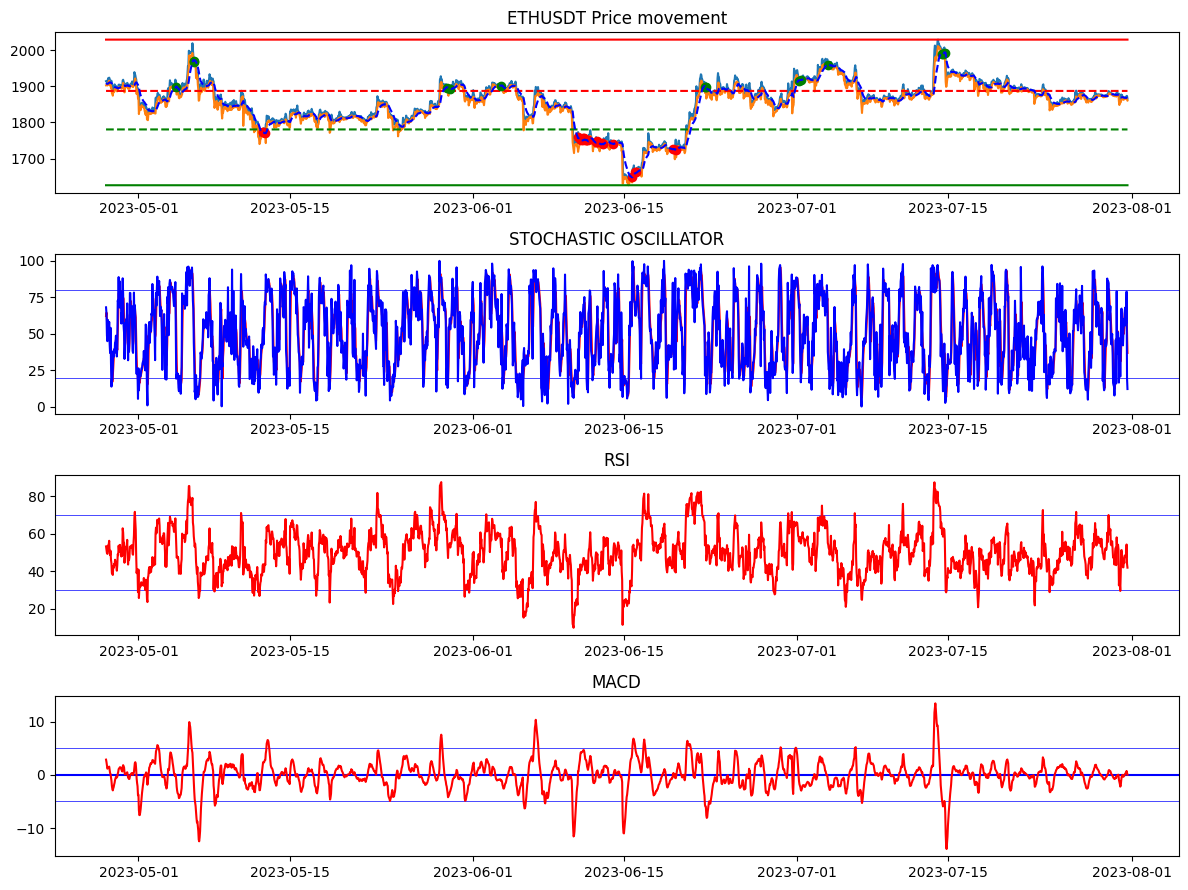

In [198]:
signal = long_short_decide(hour4, min30)
print("SIGNAL= ", signal)
plot_df(min30)
# plot_df(hour4)

LONGTERM and SHORTTERM data analysis

In [45]:
# select nth row
# hour4
# a = hour4.iloc[2]
# a.Low
# hour4.loc[hour4.index == '2023-06-16 08:00:00', 'Low'] = 2500
a = hour4.loc[hour4.index == '2023-06-16 08:00:00']
a.resistance

Time
2023-06-16 08:00:00    2025.048926
Name: resistance, dtype: float64

In [ ]:
min30

In [ ]:
signal = long_short_decide(hour4, min30)
signal

PLOTTING

In [ ]:
resistance(min30)
support(min30)
applytechnicals(min30)
# =============== LongTerm ============
resistance(hour4)
support(hour4)
applytechnicals(hour4)

TEST by ONE

Test with Iteration

In [ ]:
dataStart = 0
for i in range(100, len(data),100):
    # print('dataStart= ', dataStart, ' i= ', i)
    # ==== setting range of df ====
    df = data[dataStart:i]
    df['resistance'] = np.nan
    df['support'] = np.nan
    data['macd'] = np.nan
    data['rsi'] = np.nan
    data['%D'] = np.nan
    data['%K'] = np.nan
    # ===== Calculate Channel ====
    resistance(df)
    support(df)
    applytechnicals(df)
    decide()
    plot_df(df)
    print("Start= ", dataStart, " end = ", i)
    dataStart = i


УРТ ХУГАЦААГААР ХАРАХ ХЭСЭГ

In [857]:
# with indicator
# df = data
# df['resistance'] = np.nan
# df['support'] = np.nan
# # plt.plot(df.index, df.Close)
# # plt.show()
# # ===== Calculate Channel ====
resistance(df)
support(df)
decide()
# ===== PLOTLY =====
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=df['support'], line=dict(color="green", width=3), name="SUPPORT"),
                                    go.Scatter(x=df.index, y=df['resistance'], line=dict(color='red', width=3), name="RESISTANCE"),
                                    go.Scatter(x=df.index, y=df['Buy'], mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

ascending
difference =  45.394989013671875
range = 31
max=  457.0929870605469 min=  411.697998046875
ascending
difference =  14.936004638671875
range = 75
max=  304.23199462890625 min=  289.2959899902344


/tmp/ipykernel_3191/738999639.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



POLARS
update row